# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.304782
sanity check: 2.302585


In [50]:
W1 = np.random.randn(3073, 10) * 0.0001
print(np.mean(W1, axis=0))
print(np.std(W1, axis=0))

[ -4.77952264e-07  -3.47328413e-07   1.22167256e-06   2.76097635e-06
  -1.21504048e-06  -3.27367181e-06   1.75992954e-06  -2.76561789e-06
   1.80152199e-06   1.20679657e-06]
[  1.00647465e-04   9.91134785e-05   1.01119205e-04   9.99728569e-05
   9.87600444e-05   9.98522830e-05   9.91106941e-05   1.00923396e-04
   1.00776566e-04   9.99390414e-05]


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:**

Since all the weights are initialized randomly from the standard normal distribution, logits for all classes will be around the same. We can check that by running `np.mean` and `np.std` to see their statistics are around the same. Since all logits are roughly the same, by passing them through softmax we will get around the same probabiltity for each class, which is `1/C`. Therefore, for the correct class probability will also be around `1/C`. Loss of that will be `-log(1/C) = -log(0.1)`.

In [8]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 3.443112 analytic: 3.443038, relative error: 1.074983e-05
numerical: 0.637085 analytic: 0.637039, relative error: 3.577553e-05
numerical: 3.479365 analytic: 3.479374, relative error: 1.201829e-06
numerical: 2.119838 analytic: 2.120001, relative error: 3.856754e-05
numerical: 0.527883 analytic: 0.527863, relative error: 1.900054e-05
numerical: 0.247748 analytic: 0.247650, relative error: 1.974046e-04
numerical: 1.230229 analytic: 1.230375, relative error: 5.917603e-05
numerical: -1.078079 analytic: -1.077814, relative error: 1.230629e-04
numerical: 0.029285 analytic: 0.029515, relative error: 3.898095e-03
numerical: -2.209793 analytic: -2.209798, relative error: 1.225655e-06
numerical: 1.683487 analytic: 1.683764, relative error: 8.235864e-05
numerical: 1.210452 analytic: 1.206835, relative error: 1.496112e-03
numerical: 0.262259 analytic: 0.257544, relative error: 9.069383e-03
numerical: -2.438891 analytic: -2.442171, relative error: 6.721030e-04
numerical: -2.727584 analyti

In [52]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
t_naive = toc - tic
print('naive loss: %e computed in %fs' % (loss_naive, t_naive))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
t_vect = toc - tic
print(loss_vectorized)
print('vectorized loss: %e computed in %fs' % (loss_vectorized, t_vect))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

# How much faster?
print('Increase of %dx' % (t_naive / t_vect) )

naive loss: 2.304782e+00 computed in 0.131382s
2.30478243421
vectorized loss: 2.304782e+00 computed in 0.006332s
Loss difference: 0.000000
Gradient difference: 0.000000
Increase of 20x


In [42]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
# learning_rates = [1e-7, 5e-7]
# regularization_strengths = [2.5e4, 5e4]
learning_rates = [7.5e-9, 1e-8, 2.5e-8, 5e-8, 7.5e-8, 1e-7, 2.5e-7]
regularization_strengths = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# Your code

def acc(labels_pred, labels_true):
    assert len(labels_pred) == len(labels_true), "Incompatible shapes!"
    return float(np.sum(labels_pred == labels_true)) / len(labels_true)

for lr in learning_rates:
    for reg in regularization_strengths:
        print("\nTrying lr={}, reg={}".format(lr, reg))
        clf = Softmax()
        clf.train(X_train, y_train, 
                  learning_rate=lr, reg=reg, 
                  num_iters=1500, verbose=False)
        preds_train = clf.predict(X_train)
        acc_train = acc(preds_train, y_train)
        preds_val = clf.predict(X_val)
        acc_val = acc(preds_val, y_val)
        if acc_val > best_val:
            print("New best val! Old: %f, new: %f" % (best_val, acc_val))
            best_val = acc_val
            best_softmax = clf
        results[(lr, reg)] = (acc_train, acc_val)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)


Trying lr=7.5e-09, reg=10000.0
New best val! Old: -1.000000, new: 0.162000

Trying lr=7.5e-09, reg=25000.0
New best val! Old: 0.162000, new: 0.201000

Trying lr=7.5e-09, reg=50000.0

Trying lr=7.5e-09, reg=75000.0
New best val! Old: 0.201000, new: 0.234000

Trying lr=7.5e-09, reg=100000.0

Trying lr=7.5e-09, reg=250000.0
New best val! Old: 0.234000, new: 0.270000

Trying lr=7.5e-09, reg=500000.0

Trying lr=1e-08, reg=10000.0

Trying lr=1e-08, reg=25000.0

Trying lr=1e-08, reg=50000.0

Trying lr=1e-08, reg=75000.0

Trying lr=1e-08, reg=100000.0
New best val! Old: 0.270000, new: 0.289000

Trying lr=1e-08, reg=250000.0

Trying lr=1e-08, reg=500000.0

Trying lr=2.5e-08, reg=10000.0

Trying lr=2.5e-08, reg=25000.0

Trying lr=2.5e-08, reg=50000.0
New best val! Old: 0.289000, new: 0.318000

Trying lr=2.5e-08, reg=75000.0

Trying lr=2.5e-08, reg=100000.0

Trying lr=2.5e-08, reg=250000.0

Trying lr=2.5e-08, reg=500000.0

Trying lr=5e-08, reg=10000.0

Trying lr=5e-08, reg=25000.0
New best val! 

In [43]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.362000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*: 

no it is not possible.

*Your explanation*: 

Since all logits are passed through exponential function, the loss will never be zero. In theory, we can get arbitrarily close to zero by getting a logit that has very large magnitude and is negative. Even then, it is still technically not zero.

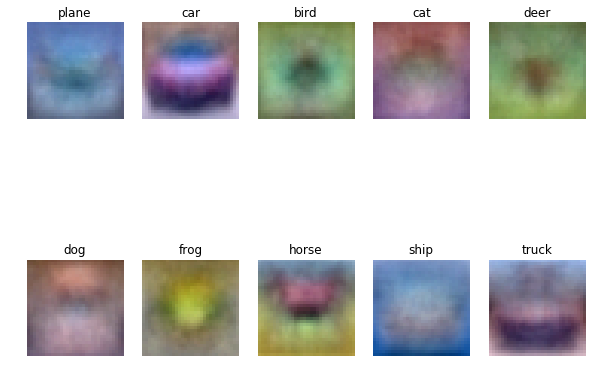

In [46]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])